<div class="alert alert-block alert-success">
    <b><center>CONVOLUTON NEURAL NETWORK</center></b>
    <b><center>Bike Share 데이터로 DNN 구현해 보기</center></b>
</div>

# Configure Learning Environment

In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [1]:
# !pip install mybatis_mapper2sql
# !pip install git+https://github.com/nockchun/rspy --force
import rspy as rsp
rsp.setSystemWarning(off=True)

2021-07-27 12:27:34.422717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

In [3]:
from sklearn import preprocessing as skpp, model_selection as skms
import tensorflow as tf
from tensorflow.keras import utils, layers, models, losses, preprocessing

In [4]:
# np.set_printoptions(linewidth=200, precision=2)
print("버전: ", tf.__version__)
print("GPU: ", "사용 가능" if tf.test.is_gpu_available() else "사용 불가능")
print("GPU Device: ", tf.config.experimental.get_visible_devices("GPU"))

버전:  2.4.1
GPU:  사용 가능
GPU Device:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-07-27 12:27:36.133924: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-27 12:27:36.135399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-27 12:27:36.169844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-27 12:27:36.170281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.

# Data Loading

* UCI Machine Learning Repository 데이터 이용
* https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset#

In [5]:
import pathlib
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
data_dir = utils.get_file('bike_share.zip', origin=dataset_url, extract=True, cache_subdir='bike_share')
data_dir = pathlib.Path(data_dir)

286720/279992 [==============================] - 1s 2us/step


In [6]:
data_dir.parent.as_posix()

'/home/rsnet/.keras/bike_share'

In [7]:
!ls /home/rsnet/.keras/bike_share

Readme.txt  bike_share.zip  day.csv  hour.csv


In [8]:
df_origin = pd.read_csv(data_dir.parent.as_posix() + "/day.csv")

In [9]:
df_origin.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [10]:
df_origin.shape

(731, 16)

# Data Exploration & Analysis

## 데이터 내용
>* instant : 기록 순서
>* dteday : 기록 날짜
>* season : 계절 [1:봄, 2:여름, 3:가을, 4:겨울]
>* yr : 년
>* mnth : 월 [1-12]
>* holiday : 국경일 유무 [0:무, 1:유]
>* weekday : 요일 [0:일, 1:월, 2:화, 3:수, 4:목, 5:금, 6:토]
>* workingday : 휴무일 유무 [0:일하는 날, 1:쉬는 날]
>* weathersit
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
>* temp : 정규화된 섭씨 온도(℃)
>* atemp : 정규화된 체감 온도. (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50
>* hum : 정규화된 습도.
>* windspeed : 정규화된 풍속.
>* casual : 일반 사용자.
>* registered : 예약 사용자.
>* cnt : 일반 + 예약 사용자. (전체 사용자)

In [11]:
cols = ["season", "mnth", "holiday", "weekday", "workingday", "weathersit", "atemp", "hum", "windspeed"]
@interact(compare=cols)
def exploration(compare):
    fig, ax1 = plt.subplots(figsize=(30, 8))
    ax2 = ax1.twinx()
    
    ax1.plot(df_origin.cnt.values, color="#3186ad", label="cnt")
    ax1.plot(df_origin.casual.values, color="#bebebe", label="casual")
    ax1.plot(df_origin.registered.values, color="#878787", label="registered")
    ax1.set_ylabel("cnt")

    ax2.plot(df_origin[compare].values, color="red", alpha=0.7, label="compare")
    ax2.set_ylabel(compare)
    
    ax1.legend(title="Species", loc="upper left")
    plt.show()

interactive(children=(Dropdown(description='compare', options=('season', 'mnth', 'holiday', 'weekday', 'workin…

# Preprocessing Data

In [12]:
print(list(df_origin.columns))

['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


In [13]:
df_preproc = df_origin[["holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed", "cnt"]]
df_preproc.head()

,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## one-hot encoding

In [14]:
onehotWeekday = pd.get_dummies(df_preproc["weekday"], prefix="weekday")
onehotWeathersit = pd.get_dummies(df_preproc["weathersit"], prefix="weathersit")
onehotWeekday.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0


In [15]:
df_preproc = df_preproc.join(onehotWeekday).join(onehotWeathersit)
df_preproc.head()

,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0,0,0,0,0,0,1,0,1,0
1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,0,0,0,0,1,0
2,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,0,0,0,0,0,1,0,0
3,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,0,1,0,0,0,0,1,0,0
4,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,0,0,1,0,0,0,1,0,0


In [16]:
df_preproc.weathersit.unique()

array([2, 1, 3])

## Scaling Y

In [17]:
scalerCnt = skpp.MinMaxScaler((0, 1))

In [18]:
scaledCnt = scalerCnt.fit_transform(df_preproc["cnt"].values.reshape(len(df_preproc["cnt"]), 1))

In [19]:
df_preproc["cntscl"] = scaledCnt
df_preproc.head()

,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,cntscl
0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0,0,0,0,0,0,1,0,1,0,0.110792
1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,0,0,0,0,1,0,0.089623
2,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,0,0,0,0,0,1,0,0,0.152669
3,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,0,1,0,0,0,0,1,0,0,0.177174
4,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,0,0,1,0,0,0,1,0,0,0.181546


In [20]:
scalerCnt.transform([[985]])

array([[0.11079153]])

In [21]:
scalerCnt.inverse_transform([[0.11079153]])

array([[984.99997876]])

# Prepare Data

In [22]:
preproc_data = df_preproc[["holiday", "workingday", "temp", "atemp", "hum", "windspeed",
     "weekday_0", "weekday_1", "weekday_2", "weekday_3", "weekday_4", "weekday_5", "weekday_6",
     "weathersit_1", "weathersit_2", "weathersit_3", "cntscl"]].values
preproc_label = df_preproc[["cntscl"]].values
preproc_data.shape, preproc_label.shape

((731, 17), (731, 1))

## Splitting

In [23]:
SIZE_VALI  = 50
SIZE_TEST  = 50
SIZE_TRAIN = preproc_data.shape[0] - SIZE_VALI - SIZE_TEST
SIZE_TRAIN

631

In [24]:
train_data = preproc_data[:SIZE_TRAIN]
test_data = preproc_data[SIZE_TRAIN: -SIZE_VALI]
vali_data = preproc_data[-SIZE_VALI:]
train_data.shape, test_data.shape, vali_data.shape

((631, 17), (50, 17), (50, 17))

In [25]:
train_label = preproc_label[:SIZE_TRAIN]
test_label = preproc_label[SIZE_TRAIN: -SIZE_VALI]
vali_label = preproc_label[-SIZE_VALI:]
train_label.shape, test_label.shape, vali_label.shape

((631, 1), (50, 1), (50, 1))

## Windowing

In [26]:
SIZE_FEATURES = train_data.shape[1]
SIZE_TRAIN_DATA = 128 # train_data.shape[0]
TIME_STEP = 5
SIZE_FEATURES, SIZE_TRAIN_DATA

(17, 128)

In [27]:
train_window = preprocessing.sequence.TimeseriesGenerator(
    train_data, train_label, length=TIME_STEP, batch_size=SIZE_TRAIN_DATA
)

In [28]:
vali_window = preprocessing.sequence.TimeseriesGenerator(
    vali_data, vali_label, length=TIME_STEP, batch_size=1
)

In [29]:
test_window = preprocessing.sequence.TimeseriesGenerator(
    test_data, test_label, length=TIME_STEP, batch_size=1
)

In [30]:
len(test_window)

45

In [31]:
x, y = test_window[0]
print(x.tolist())
print(y)

[[[0.0, 0.0, 0.529167, 0.518933, 0.467083, 0.223258, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.9071560055223193], [0.0, 1.0, 0.514167, 0.502513, 0.492917, 0.142404, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.8529682466635987], [0.0, 1.0, 0.55, 0.544179, 0.57, 0.236321, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.8647031753336402], [0.0, 1.0, 0.635, 0.596613, 0.630833, 0.2444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.8871375977910723], [0.0, 1.0, 0.65, 0.607975, 0.690833, 0.134342, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.8480211688909343]]]
[[0.85055223]]


# Generate Model

In [32]:
model = models.Sequential([
    layers.Input([TIME_STEP, SIZE_FEATURES]),
    layers.SimpleRNN(20, return_sequences=True),
    layers.TimeDistributed(layers.Dropout(.2)),
    layers.SimpleRNN(20),
    layers.Dropout(.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5, 20)             760       
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 20)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


2021-07-27 12:27:39.366637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-27 12:27:39.367219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-07-27 12:27:39.367260: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-07-27 12:27:39.367324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-07-27 12:27:39.367356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-07-27 12:27:39.367381: I tensorflow/stream_executor/

In [33]:
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)

# Training

In [34]:
history = model.fit_generator(
    train_window,
    epochs=100,
    verbose=1,
    validation_data=vali_window
)

Epoch 1/100


2021-07-27 12:27:39.631293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-27 12:27:39.654166: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
2021-07-27 12:27:40.497050: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


5/5 [==============================] - 2s 148ms/step - loss: 0.9252 - val_loss: 0.9128
Epoch 2/100
5/5 [==============================] - 0s 32ms/step - loss: 1.0261 - val_loss: 0.8273
Epoch 3/100
5/5 [==============================] - 0s 36ms/step - loss: 0.9320 - val_loss: 0.7499
Epoch 4/100
5/5 [==============================] - 0s 32ms/step - loss: 0.7574 - val_loss: 0.6793
Epoch 5/100
5/5 [==============================] - 0s 29ms/step - loss: 0.8161 - val_loss: 0.6138
Epoch 6/100
5/5 [==============================] - 0s 29ms/step - loss: 0.7139 - val_loss: 0.5543
Epoch 7/100
5/5 [==============================] - 0s 29ms/step - loss: 0.6762 - val_loss: 0.4996
Epoch 8/100
5/5 [==============================] - 0s 28ms/step - loss: 0.6010 - val_loss: 0.4506
Epoch 9/100
5/5 [==============================] - 0s 29ms/step - loss: 0.5473 - val_loss: 0.4065
Epoch 10/100
5/5 [==============================] - 0s 29ms/step - loss: 0.6003 - val_loss: 0.3669
Epoch 11/100
5/5 [============

<AxesSubplot:>

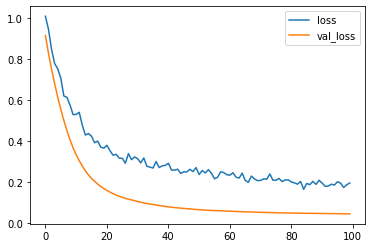

In [35]:
df_history = pd.DataFrame(history.history)
df_history[["loss", "val_loss"]].plot()

# Predict

In [36]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(test_window)):
    x, y = test_window[i]
    yhat = model.predict(x)
    df_result = df_result.append({
        'Actual': scalerCnt.inverse_transform(y)[0][0],
        'Prediction': scalerCnt.inverse_transform(yhat)[0][0]},
        ignore_index=True
    )

In [37]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']
df_result.head()

,Actual,Prediction,Diff
0,7415.0,6766.774902,-8.742078
1,8555.0,5924.124023,-30.752495
2,6889.0,6097.963379,-11.482604
3,6778.0,4440.756348,-34.482792
4,4639.0,4522.245117,-2.516811


<AxesSubplot:>

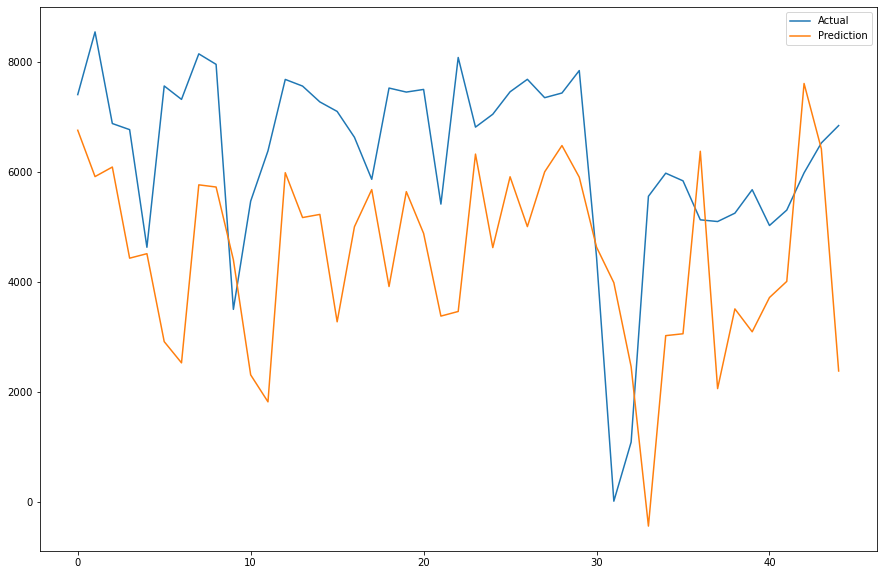

In [38]:
df_result[["Actual", "Prediction"]].plot(figsize=(15, 10))